In [2]:
import sys
import h5py
from pathlib import Path
import zipfile, os, sys
import numpy as np
from collections import defaultdict
import re
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random

ROOT = Path.cwd().parent          
SRC  = ROOT / "src"
sys.path.insert(0, str(SRC))      

from fashiongen_h5_loader import (
    ensure_h5_ready, build_vocab_from_h5, make_loaders_with_existing_val, read_label_ids_from_h5
)

# 1. Import Data

In [3]:
DATA_DIR = ROOT / "data"
assert DATA_DIR.exists(), f"Missing data dir: {DATA_DIR}"
print("DATA_DIR:", DATA_DIR)

DATA_DIR: /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data


In [4]:
# 1) Unzip both train/validation if needed; search h5 recursively
h5s = []
for zp in sorted(DATA_DIR.glob("*.zip")):
    out_dir = DATA_DIR / zp.stem
    out_dir.mkdir(parents=True, exist_ok=True)
    # extract only missing files
    with zipfile.ZipFile(zp, "r") as zf:
        for m in zf.infolist():
            # skip macOS metadata
            if m.filename.startswith("__MACOSX/"): 
                continue
            target = out_dir / m.filename
            if not target.exists():
                zf.extract(m, out_dir)
    # collect any .h5 inside (recursively)
    h5s.extend(sorted(out_dir.rglob("*.h5")))

In [5]:
h5s = sorted(set(h5s))
print("Found H5 files:")
for p in h5s: print(" -", p)

Found H5 files:
 - /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/fashiongen_256_256_train.h5/fashiongen_256_256_train.h5
 - /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/fashiongen_256_256_validation.h5/fashiongen_256_256_validation.h5


In [5]:
# 2) Identify splits by filename
lower = [p.name.lower() for p in h5s]
train_h5 = next((str(p) for p in h5s if "train" in p.name.lower()), None)
val_h5   = next((str(p) for p in h5s if "val" in p.name.lower() or "validation" in p.name.lower()), None)
test_h5  = next((str(p) for p in h5s if "test" in p.name.lower()), None)
print("train_h5:", train_h5)
print("val_h5  :", val_h5)
print("test_h5 :", test_h5)


train_h5: /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/fashiongen_256_256_train.h5/fashiongen_256_256_train.h5
val_h5  : /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/fashiongen_256_256_validation.h5/fashiongen_256_256_validation.h5
test_h5 : None


In [6]:
# 3.1) Build label vocab from train 
label_vocab_path = ROOT / "data/label_vocab.json"
_ = build_vocab_from_h5(
    train_h5,
    label_key="input_category",  
    add_other=True,
    min_count=5,
    out_json=str(label_vocab_path)
)

[vocab:input_category] Saved 49 labels to /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/label_vocab.json


In [7]:
# 3.2) Build gender vocab from train 
gender_vocab_path = ROOT / "data/gender_vocab.json"
_ = build_vocab_from_h5(
    train_h5,
    label_key="input_gender",  
    add_other=True,
    min_count=5,
    out_json=str(gender_vocab_path)
)

[vocab:input_gender] Saved 2 labels to /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/gender_vocab.json


In [ ]:
# 4) Build datasets/loaders

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders_with_existing_val(
    train_h5=train_h5,
    val_h5=val_h5,
    vocab_label_json=str(label_vocab_path),
    vocab_gender_json=str(gender_vocab_path),  
    image_key="input_image",
    label_key="input_category",
    caption_key_candidates=("input_name"),
    label_key_candidates=("input_name"),
    train_ratio=0.8,     # 80/20 split of the TRAIN file into train/test
    batch_size=64,
    num_workers=8,
    normalize="imagenet",
)
print("train/val/test lens:", len(train_ds), len(val_ds), len(test_ds))

train/val/test lens: 208375 32528 52115


In [41]:
print("image_key:", train_ds.image_key)
print("label_key:", train_ds.label_key)
print("caption_key:", train_ds.caption_key)

image_key: input_image
label_key: None
caption_key: None


In [11]:
with h5py.File(train_h5, "r") as f:
    for k in [train_ds.image_key, train_ds.label_key, train_ds.caption_key]:
        if k is None: 
            continue
        d = f[k]
        print(f"{k}: shape={getattr(d,'shape',None)}, dtype={getattr(d,'dtype',None)}")

input_image: shape=(260490, 256, 256, 3), dtype=uint8
input_category: shape=(260490, 1), dtype=|S100
input_description: shape=(260490, 1), dtype=|S400


In [14]:
# 5) Batch sanity
b = next(iter(train_loader))
print(b["image"].shape, b["label"].shape)

torch.Size([64, 3, 256, 256]) torch.Size([64])


In [15]:
print(b["image"].shape, b["label"][:8], b["gender"][:8])

torch.Size([64, 3, 256, 256]) tensor([15, 42, 37, 38, 42, 42, 20, 19]) tensor([1, 1, 1, 1, 0, 0, 0, 1])


# 2 Check Label Dist

In [16]:
# 1) Build id → name map
with open(label_vocab_path) as f:
    vocab = json.load(f)
    
id2label = {int(v): k for k, v in vocab.items()}

In [36]:
with open(gender_vocab_path) as f:
    gen_vocab = json.load(f)
id2gen = {int(v): k for k, v in gen_vocab.items()}

In [17]:
print("vocab size:", len(vocab))
print("first keys:", list(vocab)[:10])

vocab size: 49
first keys: ['__other__', 'backpacks', 'bag accessories', 'belts & suspenders', 'blankets', 'boat shoes & moccasins', 'boots', 'briefcases', 'clutches & pouches', 'dresses']


In [19]:
# 2) TRAIN: read all label ids from the train .h5, then subset to your dataset's keep_idx
train_labels_all = read_label_ids_from_h5(train_h5, label_key="input_category", vocab_json=str(label_vocab_path))
train_labels = train_labels_all[np.asarray(train_ds.keep_idx)]

In [20]:
# 3) VAL / TEST (if you built test from train, skip keep_idx for val_h5)
val_labels   = read_label_ids_from_h5(val_h5,   label_key="input_category", vocab_json=str(label_vocab_path))
test_labels  = read_label_ids_from_h5(train_h5, label_key="input_category", vocab_json=str(label_vocab_path))
test_labels  = test_labels[np.asarray(test_ds.keep_idx)]   

In [21]:
# 4) Make pretty tables
def counts_table(labels_np):
    s = pd.Series(labels_np)
    tbl = (s.value_counts()
             .rename_axis("label_id")
             .reset_index(name="n")
             .assign(category=lambda df: df["label_id"].map(id2label))
             .sort_values("n", ascending=False)
             .reset_index(drop=True))
    return tbl[["category","n","label_id"]]


train_counts = counts_table(train_labels)
val_counts   = counts_table(val_labels)
test_counts  = counts_table(test_labels)

In [22]:

print("TRAIN (top 20):")
print(train_counts.head(20).to_string(index=False))

print("\nVAL (top 20):")
print(val_counts.head(20).to_string(index=False))

print("\nTEST (top 20):")
print(test_counts.head(20).to_string(index=False))

TRAIN (top 20):
       category     n  label_id
           tops 38211        45
       sweaters 35672        42
jackets & coats 28028        19
          pants 18584        30
          jeans 10868        20
         shirts  9118        35
       sneakers  8382        39
        dresses  7566         9
         shorts  5932        36
  shoulder bags  5561        37
         skirts  5527        38
        jewelry  3946        21
           hats  3636        17
          boots  3612         6
          flats  3084        15
        sandals  2812        33
      backpacks  2286         1
suits & blazers  2276        41
        eyewear  1995        13
      tote bags  1824        46

VAL (top 20):
       category    n  label_id
           tops 5944        45
       sweaters 5602        42
jackets & coats 4357        19
          pants 2910        30
          jeans 1694        20
         shirts 1418        35
       sneakers 1306        39
        dresses 1184         9
         shorts  9

# 3. Quick Peek of the Dataset

In [23]:
import json, re, numpy as np, h5py
from pathlib import Path

# --- helpers copied from your loader ---
def _decode_bytes(x):
    import numpy as np
    if isinstance(x, np.void):
        b = bytes(x)
    elif isinstance(x, (bytes, bytearray, np.bytes_)):
        b = bytes(x)
    else:
        return str(x)
    b = b.split(b"\x00", 1)[0]
    for enc in ("utf-8", "latin-1"):
        try: return b.decode(enc)
        except UnicodeDecodeError: pass
    return b.decode("utf-8", errors="ignore")

def _as_scalar(x):
    import numpy as np
    if isinstance(x, np.ndarray):
        return x.squeeze().item() if x.ndim > 0 else x.item()
    return x

def _norm(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).strip().lower())

# --- load vocab actually used by the dataset ---
with open(label_vocab_path) as f:
    vocab = json.load(f)
print("vocab size:", len(vocab))
print("first 10 vocab keys:", list(vocab.keys())[:10])

# --- peek raw/decoded/normalized vs membership ---
with h5py.File(train_h5, "r") as f:
    d = f["input_category"]   # change if needed
    N = d.shape[0]
    idxs = np.random.default_rng(0).choice(N, size=20, replace=False)
    rows = []
    for i in idxs:
        raw = _as_scalar(d[i])
        dec = _decode_bytes(raw)
        norm = _norm(dec)
        rows.append((i, dec, norm, norm in vocab))
rows[:5], sum(r[3] for r in rows)

vocab size: 49
first 10 vocab keys: ['__other__', 'backpacks', 'bag accessories', 'belts & suspenders', 'blankets', 'boat shoes & moccasins', 'boots', 'briefcases', 'clutches & pouches', 'dresses']


([(237756, 'FLATS', 'flats', True),
  (80181, 'TOPS', 'tops', True),
  (70272, 'DRESSES', 'dresses', True),
  (243577, 'SKIRTS', 'skirts', True),
  (133137, 'PANTS', 'pants', True)],
 20)

In [24]:
with open(label_vocab_path) as f: vocab = json.load(f)
print("vocab size:", len(vocab))
print("has input categories like 'dress'?", any("dress" in k for k in vocab.keys()))

vocab size: 49
has input categories like 'dress'? True


In [25]:
id2label

{0: '__other__',
 1: 'backpacks',
 2: 'bag accessories',
 3: 'belts & suspenders',
 4: 'blankets',
 5: 'boat shoes & moccasins',
 6: 'boots',
 7: 'briefcases',
 8: 'clutches & pouches',
 9: 'dresses',
 10: 'duffle & top handle bags',
 11: 'duffle bags',
 12: 'espadrilles',
 13: 'eyewear',
 14: 'fine jewelry',
 15: 'flats',
 16: 'gloves',
 17: 'hats',
 18: 'heels',
 19: 'jackets & coats',
 20: 'jeans',
 21: 'jewelry',
 22: 'jumpsuits',
 23: 'keychains',
 24: 'lace ups',
 25: 'lingerie',
 26: 'loafers',
 27: 'messenger bags',
 28: 'messenger bags & satchels',
 29: 'monkstraps',
 30: 'pants',
 31: 'pocket squares & tie bars',
 32: 'pouches & document holders',
 33: 'sandals',
 34: 'scarves',
 35: 'shirts',
 36: 'shorts',
 37: 'shoulder bags',
 38: 'skirts',
 39: 'sneakers',
 40: 'socks',
 41: 'suits & blazers',
 42: 'sweaters',
 43: 'swimwear',
 44: 'ties',
 45: 'tops',
 46: 'tote bags',
 47: 'travel bags',
 48: 'underwear & loungewear'}

In [26]:
print("len(train_ds):", len(train_ds))
print("keep_idx example:", train_ds.keep_idx[:5], "max raw:", int(np.max(train_ds.keep_idx)))

len(train_ds): 208375
keep_idx example: [ 42290 127284  20656  74607 107000] max raw: 260489


In [27]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_img(img_t: torch.Tensor, norm="imagenet"):
    if norm == "imagenet":
        x = img_t * IMAGENET_STD + IMAGENET_MEAN
    elif norm == "gan":
        x = (img_t * 0.5) + 0.5
    else:
        x = img_t
    return x.clamp(0,1)

def show_samples(ds, idxs=None, n=8, ncols=4, norm="imagenet", id2label=None, figsize=(14, 8)):
    """
    idxs refer to **dataset indices**: 0..len(ds)-1.
    If idxs is None, we sample uniformly from that range.
    """
    N = len(ds)
    if idxs is None:
        n = min(n, N)
        idxs = np.random.default_rng(0).choice(np.arange(N), size=n, replace=False)
    else:
        idxs = [int(i) for i in idxs]
        for i in idxs:
            if not (0 <= i < N):
                raise IndexError(f"Dataset index {i} out of range [0, {N})")

    n = len(idxs)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols

    plt.figure(figsize=figsize)
    for pos, i in enumerate(idxs, 1):
        ex = ds[i]  # safe: dataset index
        img = denorm_img(ex["image"], norm=norm).permute(1,2,0).cpu().numpy()
        y = ex["label"]
        yname = id2label.get(int(y), str(y)) if id2label is not None else str(y)
        cap = ex.get("caption", "")
        cap = cap if isinstance(cap, str) else str(cap)
        if len(cap) > 80: cap = cap[:80] + "…"

        ax = plt.subplot(nrows, ncols, pos)
        ax.imshow(img); ax.axis("off")
        ax.set_title(f"{y} | {yname}", fontsize=10)
        ax.set_xlabel(cap, fontsize=9)
    plt.tight_layout()
    plt.show()

def show_by_raw_index(ds, raw_idxs, **kw):
    """
    Peek items by **raw H5 indices** (values inside ds.keep_idx).
    We convert each raw index to its dataset index first.
    """
    raw_idxs = [int(r) for r in raw_idxs]
    keep = np.asarray(ds.keep_idx)
    inv = {int(k): j for j, k in enumerate(keep)}  # raw->dataset
    ds_idxs = []
    missing = []
    for r in raw_idxs:
        j = inv.get(int(r))
        if j is None:
            missing.append(r)
        else:
            ds_idxs.append(j)
    if missing:
        print(f"(skipped {len(missing)} raw indices not in subset): {missing[:10]}")
    return show_samples(ds, idxs=ds_idxs, **kw)

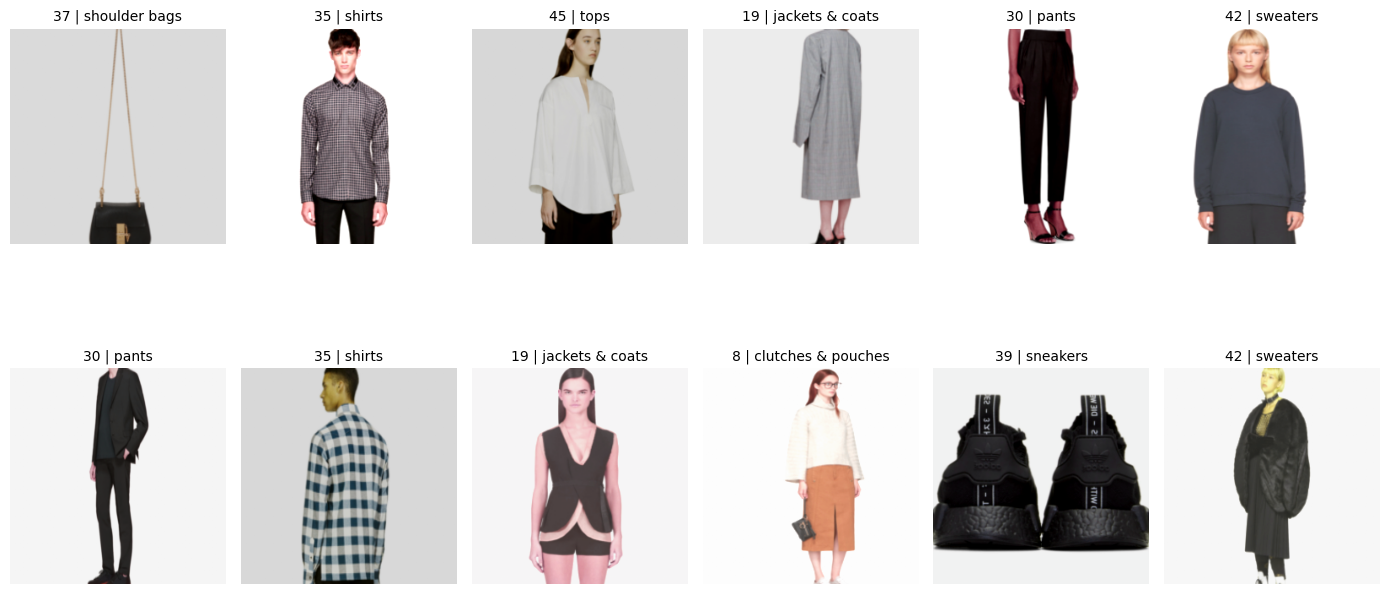

In [28]:
show_samples(train_ds, n=12, ncols=6, norm="imagenet", id2label=id2label)


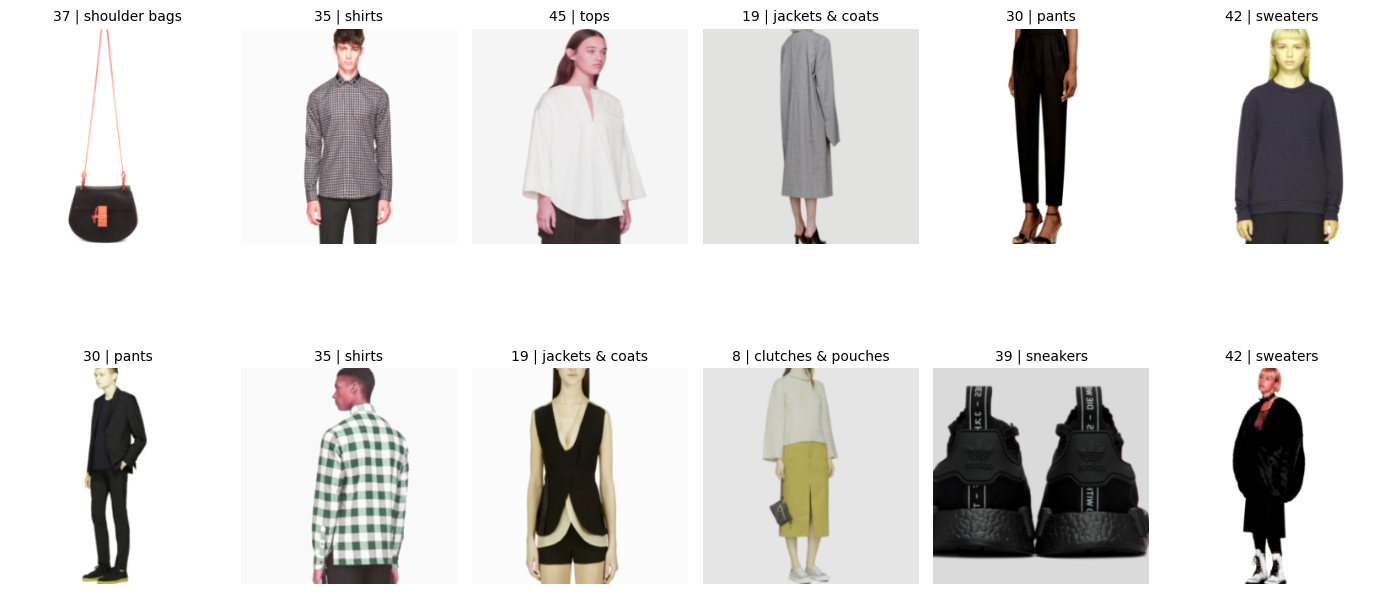

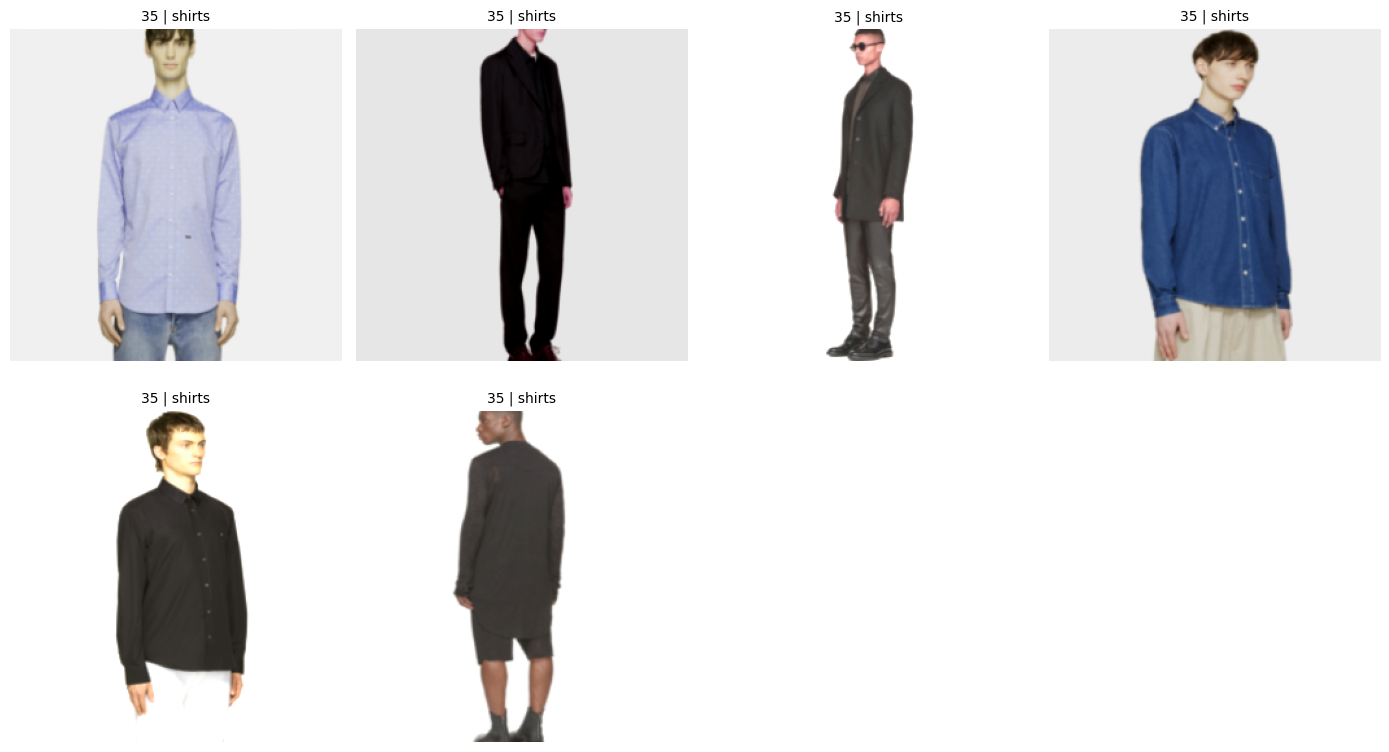

(skipped 1 raw indices not in subset): [12345]


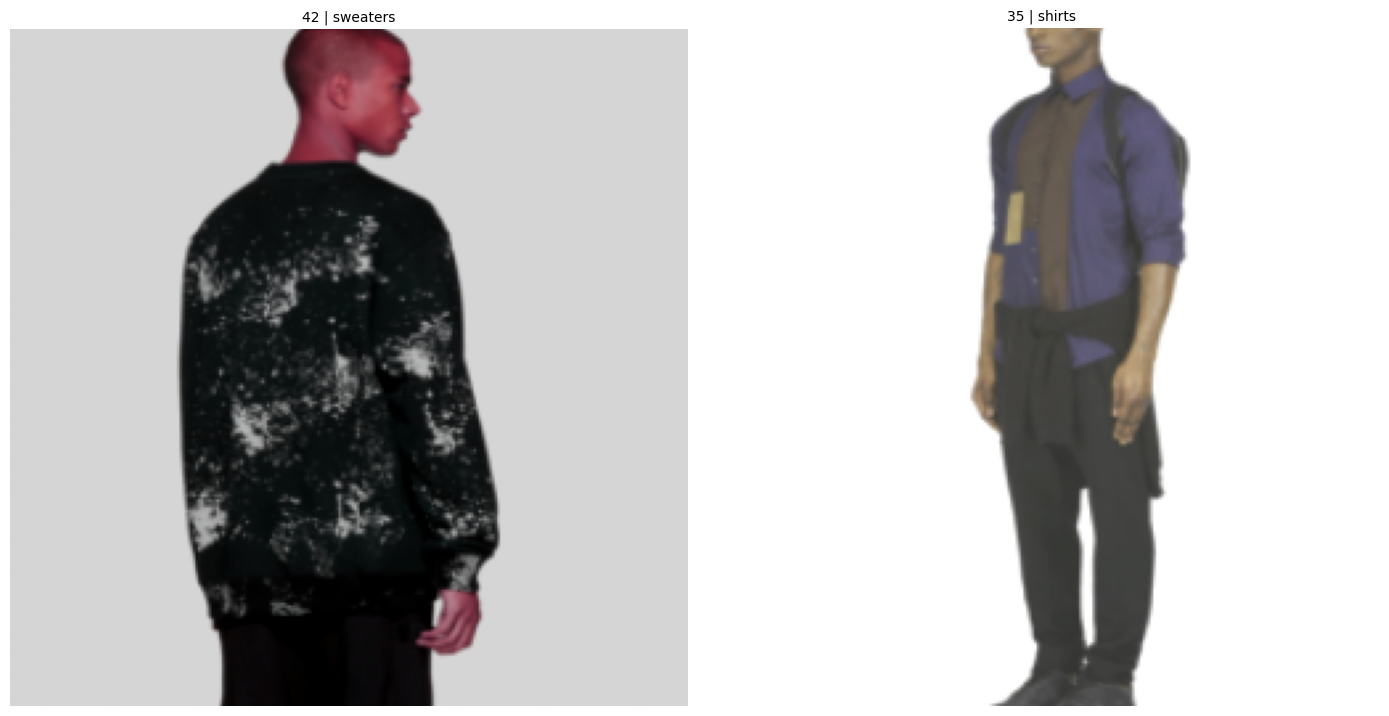

In [ ]:
# Random dataset indices
show_samples(train_ds, n=12, ncols=6, norm="imagenet", id2label=id2label)

# Exact dataset indices
show_samples(train_ds, idxs=[0,1,2,3,4,5], id2label=id2label)

# Peek by raw H5 indices (from the original file):
show_by_raw_index(train_ds, raw_idxs=[257594, 100, 12345], id2label=id2label)

In [37]:
print("Dataset length:", len(train_ds))
for i in random.sample(range(len(train_ds)), k=5):
    ex = train_ds[i]
    cat = id2label.get(int(ex["label"]), ex["label"])
    gen = id2gen.get(int(ex["gender"]), ex["gender"])
    cap = (ex["caption"] or "")[:140].replace("\n"," ")
    print(f"[{i}] category={cat} | gender={gen} | caption='{cap}'")

Dataset length: 208375
[95185] category=tops | gender=men | caption='Short sleeve silk jersey t-shirt in navy. Raw edges and slub texture throughout. Crewneck collar. Tonal stitching.'
[35584] category=sweaters | gender=men | caption='Long sleeve bouclé knit merino wool-blend sweater in black. Mock neck collar. Self-tie straps featuring concealed metal aglets at side-seams'
[27612] category=sweaters | gender=women | caption='Long sleeve wool sweater in black. Contrasting rib knit at crewneck collar and sleeves in navy. Removable funnel collar in navy. Tonal stitc'
[158183] category=jumpsuits | gender=women | caption='Short sleeve cotton seersucker jumpsuit in navy. Spread collar. Button closure at front. Elasticized waistband. Two-pocket styling. Rolled s'
[42451] category=sweaters | gender=men | caption='Long sleeve knit cashmere sweater striped in tones of black and white. Rib knit crewneck collar, cuffs, and hem. Tonal stitching.'
